In [1]:
# Load packages and set up paths
%load_ext autoreload
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import sys
import tensorflow as tf
import tensorflow.keras.backend as K
import cartopy.crs as ccrs

# my working paths
sys.path.append(r'/home/u1281808/High-res-interpretable-dl/src')
# change to the directory of the "src file" 
os.chdir(r'/home/u1281808/High-res-interpretable-dl')

from dask.diagnostics import ProgressBar
import cmocean
from models import train_model, complex_conv, simple_conv, predict, simple_dense, linear_complex_model
from losses import gamma_loss_1d, gamma_mse_metric
from prepare_data import format_features, prepare_training_dataset, create_test_train_split

from sklearn.metrics import explained_variance_score, mean_squared_error

tf.random.set_seed(2)

2024-12-09 02:46:46.259820: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 02:46:47.340405: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 02:46:47.341390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 02:46:55.894551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import random

# Hyperparameter ranges
# dependance between layer number and model depth
layer_neuron_map = {
    3: [16, 32, 64],
    4: [16, 32, 64, 128],
    5: [16, 32, 64, 128, 256]
}
kernel_size_options = [(3, 3), (5, 5), (7, 7)]
learning_rate_options = [1e-4, 1e-3, 1e-2]
dropout_options = [0.3, 0.4, 0.5, 0.6, 0.7]
batch_size_options = [16, 32, 64]

# Data preparation
config = dict(y = "/home/u1281808/High-res-interpretable-dl/training_data/topography_subset_full.nc",
              X = "/home/u1281808/High-res-interpretable-dl/training_data/ERA5_training_dataset_6_3_23_bilinear_half_degree.nc",
              train_start = "1982-01-01",
              train_end = "2011-12-31",
              val_start = "2012-01-01",
              val_end = "2014-12-31",
              test_start = "2015-01-01",
              test_end = "2018-12-31",
              downscale_variables = ['w_850', 'u_850', 'v_850', 'q_850', 't_850'])

x_train, x_val, x_test, y_train, y_val, y_test = create_test_train_split(config)
x_train, x_test, x_val, y_train, y_test, y_val = prepare_training_dataset(x_train, x_val, x_test, y_train, y_val, y_test)

x_train_np, x_val_np, x_test_np = x_train.values, x_val.values, x_test.values
y_train_np, y_val_np, y_test_np = y_train['pr'].values, y_val['pr'].values, y_test['pr'].values

input_shape = x_train_np.shape[1:]
output_shape = y_train_np.shape[1]


[########################################] | 100% Completed | 7.49 ss
[########################################] | 100% Completed | 1.52 ss
[########################################] | 100% Completed | 1.52 sms
[########################################] | 100% Completed | 101.70 ms
[########################################] | 100% Completed | 404.33 ms
[########################################] | 100% Completed | 102.92 ms


In [3]:
import json

# Random search configuration
# trial number 
n_iterations = 10
results = []  # Track all trials
best_val_mse = float("inf")
best_config = None
best_model_weights = "best_CNN_Gamma_weights.h5"  # File to save the best model weights

for i in range(n_iterations):
    print(f"Iteration {i+1}/{n_iterations}")
    
    # Randomly select hyperparameters
    num_layers = random.choice(list(layer_neuron_map.keys()))
    layer_filters = layer_neuron_map[num_layers]
    kernel_size = random.choice(kernel_size_options)
    learning_rate = random.choice(learning_rate_options)
    dropout_rate = random.choice(dropout_options)
    batch_size = random.choice(batch_size_options)

    print(f"Testing configuration: layers={layer_filters}, kernel_size={kernel_size}, "
          f"learning_rate={learning_rate}, dropout_rate={dropout_rate}, batch_size={batch_size}")
    
    # Define model
    cnn_gamma = complex_conv(
        layer_filters=layer_filters,
        bn=True,
        padding='same',  # Avoid dimension shrinkage errors
        kernel_size=kernel_size,
        pooling=True,
        dense_layers=[256],

        # selu or relu
        dense_activation='relu',
        input_shape=input_shape,
        dropout=dropout_rate,
        activation='relu',
        output_shape=output_shape
    )
    
    # Compile optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Generate a unique model weights name without layer_filters
    model_weights_name = f"CNN_gamma_layers_{len(layer_filters)}_ksize_{kernel_size[0]}x{kernel_size[1]}_lr_{learning_rate:.0e}_dropout_{dropout_rate}_batch_{batch_size}.h5"

    # Train model
    history, trained_model = train_model(
        cnn_gamma,
        [x_train_np, y_train_np],
        x_val=x_val_np,
        y_val=y_val_np,
        loss=gamma_loss_1d,
        epochs=40,
        batch_size=batch_size,
        optimizer=optimizer,
        model_weights_name=model_weights_name,  # Disable saving weights for this test
        metrics=gamma_mse_metric
    )
    
    # Save trial results
    mse_history = history.history['val_gamma_mse_metric']  # Track validation MSE
    final_val_mse = mse_history[-1]  # Last validation MSE
    results.append({
        'config': {
            'num_layers': len(layer_filters),
            'kernel_size': kernel_size,
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size
        },
        'val_mse': mse_history
    })

    # Update the best configuration if the current model is better
    if final_val_mse < best_val_mse:
        print(f"New best model found with val_mse={final_val_mse}")
        best_val_mse = final_val_mse
        best_config = {
            'num_layers': len(layer_filters),
            'kernel_size': kernel_size,
            'learning_rate': learning_rate,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size
        }
        # Save the best model weights
        trained_model.save_weights(best_model_weights)

# Save all trial results
with open("CNN_gamma_hyperparameter_results.json", "w") as f:
    json.dump(results, f)

# Save the best hyperparameters
with open("best_CNN_gamma_hyperparameters.json", "w") as f:
    json.dump({'best_config': best_config, 'best_val_mse': best_val_mse}, f)

print(f"Best hyperparameters saved: {best_config} with validation MSE: {best_val_mse}")




Iteration 1/10
Testing configuration: layers=[16, 32, 64], kernel_size=(3, 3), learning_rate=0.0001, dropout_rate=0.3, batch_size=32


2024-12-09 02:49:31.906563: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-12-09 02:49:32.019695: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1794] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 67, 76, 5)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 67, 76, 16)           736       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 33, 38, 16)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 batch_normalization (Batch  (None, 33, 38, 16)           64        ['average_pooling2d[0][0]'

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



685/685 [==============================] - 48s 70ms/step - loss: 1.9414 - gamma_mse_metric: 73.1354 - val_loss: 1.8522 - val_gamma_mse_metric: 54.7811 - lr: 0.0100
Epoch 5/40
685/685 [==============================] - 48s 69ms/step - loss: 1.9275 - gamma_mse_metric: 73.1286 - val_loss: 1.8755 - val_gamma_mse_metric: 175.0332 - lr: 0.0100
Epoch 6/40
685/685 [==============================] - 48s 70ms/step - loss: 1.9187 - gamma_mse_metric: 73.3955 - val_loss: 1.8397 - val_gamma_mse_metric: 79.7607 - lr: 0.0100
Epoch 7/40
685/685 [==============================] - 48s 70ms/step - loss: 1.9122 - gamma_mse_metric: 70.0068 - val_loss: 1.8598 - val_gamma_mse_metric: 122.0391 - lr: 0.0100
Epoch 8/40
300/685 [============>.................] - ETA: 26s - loss: 1.8984 - gamma_mse_metric: 66.1922

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



685/685 [==============================] - 48s 70ms/step - loss: 1.7844 - gamma_mse_metric: 47.0529 - val_loss: 1.7501 - val_gamma_mse_metric: 45.0717 - lr: 0.0020
Epoch 15/40
685/685 [==============================] - 48s 69ms/step - loss: 1.7681 - gamma_mse_metric: 47.5212 - val_loss: 1.7394 - val_gamma_mse_metric: 44.4883 - lr: 0.0020
Epoch 17/40
685/685 [==============================] - 48s 70ms/step - loss: 1.7579 - gamma_mse_metric: 50.0615 - val_loss: 1.7469 - val_gamma_mse_metric: 50.8755 - lr: 0.0020
Epoch 18/40
685/685 [==============================] - 48s 70ms/step - loss: 1.7514 - gamma_mse_metric: 45.6223 - val_loss: 1.7300 - val_gamma_mse_metric: 43.8775 - lr: 0.0020
Epoch 19/40
685/685 [==============================] - 48s 70ms/step - loss: 1.7428 - gamma_mse_metric: 44.9185 - val_loss: 1.7338 - val_gamma_mse_metric: 43.6531 - lr: 0.0020
Epoch 20/40
685/685 [==============================] - 48s 70ms/step - loss: 1.7371 - gamma_mse_metric: 43.9245 - val_loss: 1.7389 -

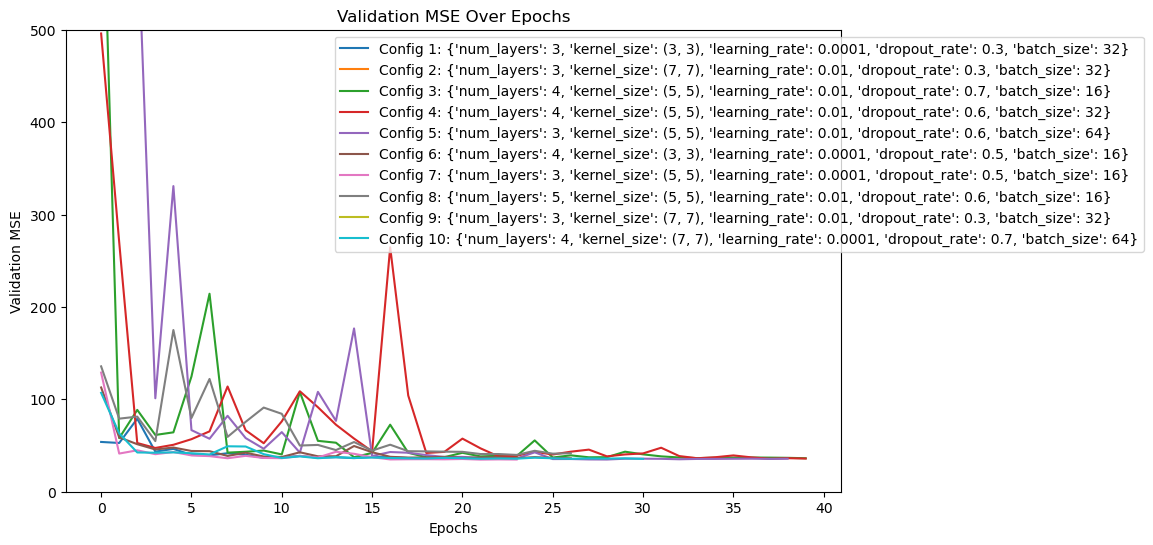

In [4]:
# Create a figure object
# Plot performance metrics
fig = plt.figure(figsize=(10, 6))
for idx, result in enumerate(results):
    plt.plot(result['val_mse'], label=f"Config {idx+1}: {result['config']}")

plt.title("Validation MSE Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation MSE")
plt.ylim(0, 500)  # Set the y-axis limits
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

fig.savefig('Hyperparameter-Tuning-CNN-Gamma-NewZealand-Relu-10trails.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close() 
